In [133]:
%matplotlib inline 
# above line allows for showing plots in a cell easily
import matplotlib # the main plotting library
#matplotlib.style.use('ggplot')
import numpy as np # allows for arrays
import matplotlib.pyplot as plt # getting specific plotting functions
import urllib # URL import functions
import pandas as pd # nice data utilities

In [134]:
q=pd.read_table('./data/log_1.csv', header=0,sep=',',names=['t','tm','s']);

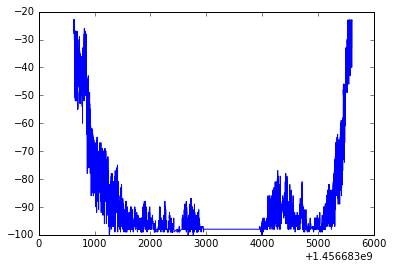

In [136]:
plt.plot(q.t,q.s); 

In [7]:
color='green'
if s<-40, color='blue' 
if x<-70, color='red'

100.0

Below is from https://ocefpaf.github.io/python4oceanographers/blog/2014/05/05/folium/ ...

In [8]:
#fname = './data/DHO.kml'
fname = './data/DHO_cwv_GoogleEarth.kml'

In [9]:
a=open(fname).read();

In [10]:
from xml.dom.minidom import parseString

In [11]:
dom=parseString(a)

In [12]:
latitudes=[]
longitudes=[]


for d in dom.getElementsByTagName('coordinates'):
    coords=d.firstChild.data.split(',')
    longitudes.append(float(coords[0]))
    latitudes.append(float(coords[1]))

In [13]:
timeList=dom.getElementsByTagName('when')
coordList=dom.getElementsByTagName('gx:coord')
placeList=dom.getElementsByTagName('TimeStamp')
#print(timeList[0].toxml())
#print(len(reflist))
print(len(timeList))
print(len(coordList))
print(len(placeList))

821
801
20


I think this means: skip the 'when' items that have 'TimeStamp' associated with them. I.e., the first len(placeList) items. 

In [14]:
times=timeList[(len(placeList)+1):];coords=coordList[:(len(coordList)-1)]

In [15]:
print(times[0].toxml())
print(coords[0].toxml())
print(len(coords)); print(len(times))

<when>2016-02-28T18:22:17.000Z</when>
<gx:coord>-70.976616 43.15733 48.8</gx:coord>
800
800


Yes, this matches the file ... 

In [16]:
t=[]
for ts in times:
    #t.append(ts.firstChild.data.split('.')[0])
    t.append(ts.firstChild.data)

In [17]:
lat=[]
lon=[]
alt=[]
for c in coords:
    thisc = c.firstChild.data.split(' ')
    lat.append(float(thisc[0]))
    lon.append(float(thisc[1]))
    alt.append(float(thisc[2]))

In [18]:
t[222]

'2016-02-28T18:42:21.000Z'

In [19]:
import time
pattern='%Y-%m-%dT%H:%M:%S.000Z'
tGPS=[]
timeShift=18000 #GPS is 5 hours off, which is 18000 seconds
for ts in t:
    thisTime=int(time.mktime(time.strptime(ts, pattern)))-timeShift
    tGPS.append(thisTime)

In [20]:
tGPS[0]

1456683737

In [21]:
tLog=[]
for ts in q.t:
    tLog.append(int(ts))

In [96]:
# start with some metric

diffBest=(tLog[0])**4

# now go through and compare
diffs=[]
fl=[] # array of indices into tLog for the closest time to any given tGPS time

for i in range(0,len(tGPS)):
    tG=tGPS[i]
    diffs=[]
    for j in range(0,len(tLog)):
        diff=(tLog[j]-tG)**2
        diffs.append(diff)
    myd=np.asarray(diffs);
    ta=np.where(myd == myd.min())
    fl.append(ta[0][0])

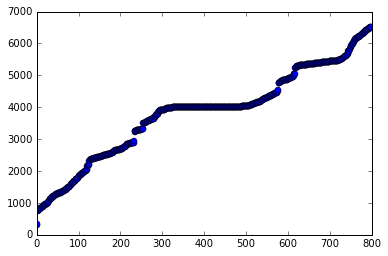

In [97]:
plt.plot(fl,'o')

In [139]:
finalC=[]
for i in range(0,len(tGPS)):
    time=tGPS[i]
    la=lat[i]
    lo=lon[i]
    strength=q.s[fl[i]]
    finalC.append((time,la,lo,strength))

In [141]:
len(finalC)

800

# KML - trial 1

In [92]:
from fastkml import kml

In [95]:
# first: pip install shapely
from shapely.geometry import Point, LineString, Polygon

In [98]:
k = kml.KML()
ns = '{http://www.opengis.net/kml/2.2}'
d = kml.Document(ns, 'docid', 'doc name', 'doc description')
k.append(d)
f = kml.Folder(ns, 'fid', 'f name', 'f description')
d.append(f)
nf = kml.Folder(ns, 'nested-fid', 'nested f name', 'nested f description')
f.append(nf)
f2 = kml.Folder(ns, 'id2', 'name2', 'description2')
d.append(f2)
p = kml.Placemark(ns, 'id', 'name', 'description')
p.geometry =  Polygon([(0, 0, 0), (1, 1, 0), (1, 0, 1)])
f2.append(p)

In [100]:
print(k.to_string(prettyprint=True))

<kml xmlns="http://www.opengis.net/kml/2.2">
  <Document id="docid">
    <name>doc name</name>
    <description>doc description</description>
    <visibility>1</visibility>
    <Folder id="fid">
      <name>f name</name>
      <description>f description</description>
      <visibility>1</visibility>
      <Folder id="nested-fid">
        <name>nested f name</name>
        <description>nested f description</description>
        <visibility>1</visibility>
      </Folder>
    </Folder>
    <Folder id="id2">
      <name>name2</name>
      <description>description2</description>
      <visibility>1</visibility>
      <Placemark id="id">
        <name>name</name>
        <description>description</description>
        <visibility>1</visibility>
        <Polygon>
          <outerBoundaryIs>
            <LinearRing>
              <coordinates>0.000000,0.000000,0.000000 1.000000,1.000000,0.000000 1.000000,0.000000,1.000000 0.000000,0.000000,0.000000</coordinates>
            </LinearRing>
      

In [107]:
# pip install pykml

from lxml import etree
from pykml.parser import Schema
from pykml.factory import KML_ElementMaker as KML
from pykml.factory import GX_ElementMaker as GX

doc = KML.kml(
    KML.Placemark(
        KML.name("gx:altitudeMode Example"),
        KML.LookAt(
            KML.longitude(146.806),
            KML.latitude(12.219),
            KML.heading(-60),
            KML.tilt(70),
            KML.range(6300),
            GX.altitudeMode("relativeToSeaFloor"),
        ),
        KML.LineString(
            KML.extrude(1),
            GX.altitudeMode("relativeToSeaFloor"),
            KML.coordinates(
              "146.825,12.233,400 "
              "146.820,12.222,400 "
              "146.812,12.212,400 "
              "146.796,12.209,400 "
              "146.788,12.205,400"
            )
        )
    )
)

print(etree.tostring(doc, pretty_print=True))

# output a KML file (named based on the Python script)
file_ = open('./test.kml','w')
stra = etree.tostring(doc, pretty_print=True)
file_.write(stra)
file_.close()
assert Schema('kml22gx.xsd').validate(doc)

# This validates:
# xmllint --noout --schema ../../pykml/schemas/kml22gx.xsd altitudemode_reference.kml

b'<kml xmlns:atom="http://www.w3.org/2005/Atom" xmlns:gx="http://www.google.com/kml/ext/2.2" xmlns="http://www.opengis.net/kml/2.2">\n  <Placemark>\n    <name>gx:altitudeMode Example</name>\n    <LookAt>\n      <longitude>146.806</longitude>\n      <latitude>12.219</latitude>\n      <heading>-60</heading>\n      <tilt>70</tilt>\n      <range>6300</range>\n      <gx:altitudeMode>relativeToSeaFloor</gx:altitudeMode>\n    </LookAt>\n    <LineString>\n      <extrude>1</extrude>\n      <gx:altitudeMode>relativeToSeaFloor</gx:altitudeMode>\n      <coordinates>146.825,12.233,400 146.820,12.222,400 146.812,12.212,400 146.796,12.209,400 146.788,12.205,400</coordinates>\n    </LineString>\n  </Placemark>\n</kml>\n'


TypeError: write() argument must be str, not bytes

# testing

In [172]:
tL=tLog[11]
d=[]
for tG in tGPS:
    d.append((tG-18000)-tL)

In [50]:
ly=[]
for i in range(0,len(tLog)):
    ly.append(1.)
gy=[]
for i in range(0,len(tGPS)):
    gy.append(2.)

In [51]:
print(len(ly));print(len(gy))

6850
800


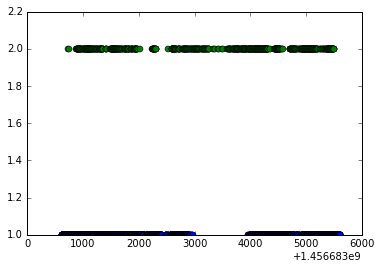

In [52]:
plt.plot(tLog,ly,'o');plt.plot(tGPS,gy,'o')

# Detecting the timeshift

In [142]:
time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(tLog[0]))

'2016-02-28 13:20:30'

In [143]:
time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(tGPS[0]))

'2016-02-28 18:22:17'

In [145]:
tGPS[0]-tLog[0]

18107

So, we're off by 5 hours ...

In [146]:
5*60*60

18000

# KML

http://fredgibbs.net/tutorials/create-kml-file-python.html

In [119]:
# pip install simplekml

import csv

import simplekml

inputfile = csv.reader(open('./data/test.csv','r'))
kml=simplekml.Kml()

for row in inputfile:
    print(row
    kml.newpoint(name=row[0], coords=[(row[2],row[1])])

kml.save('battleplaces.kml')

["'Charleston County'", '32.7956561', '-79.7848422']
["'Norfolk City'", '36.8507689', '-76.2858726']
["'Stafford County'", '38.4334566', '-77.4242972']
["'Barbour County'", '39.1398692', '-80.0087746']
["'York County'", '37.2103925', '-76.3868797']


In [146]:
# pip install simplekml

import csv

import simplekml


kml=simplekml.Kml()

for row in finalC:
    kml.newpoint(name='',coords=[(row[1],row[2],row[3])])
    
kml.save('out.kml')
    
    #ls.coods=coords
#ls.extrude=1
#ls.altitudemode = simplekml.AltitudeMode.relativetoground
#kml.save("line.kml")

# Using Folium ...

http://folium.readthedocs.org/en/latest/quickstart.html#getting-started

http://nbviewer.jupyter.org/github/ocefpaf/folium_notebooks/blob/master/test_heatmap.ipynb

In [183]:
# pip install folium
import folium

a=43.15733
b=-70.976616

map_osm = folium.Map(location=[43.15733,-70.976616],zoom_start=13)

'''
folium.RegularPolygonMarker(
    [43.15733,-70.976616],
    popup='Ross Island Bridge',
    fill_color='#132b5e',
    number_of_sides=3,
    radius=10
    ).add_to(map_osm)
'''

kw = dict(opacity=1.0, weight=4)

for i in range(1,len(finalC)):
    rowBack=finalC[i-1]
    row=finalC[i]
    
    coordBack=(rowBack[2],rowBack[1])
    coord=(row[2],row[1])
    loc=[coordBack,coord]
    
    #signal strength 
    s=row[3]
    c='green'
    if (s<-90):
        c='blue' 
    if (s<-95):
        c='red'

    l = folium.PolyLine(locations=loc, color=c, **kw)
     
    map_osm.add_children(l)

map_osm

In [149]:
# pip install vincent


(1456683737, -70.976616, 43.15733, -43)

In [180]:
plt.plot(finalC[:,3])

TypeError: list indices must be integers or slices, not tuple